In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [ ]:
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # Reserve 10% for validation and 10% for test
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Include labels
)

print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print(
    "Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds)
)
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteGSB6W2/cats_vs_dogs-train.tfrecord
Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.
Number of training samples: 9305
Number of validation samples: 2326
Number of test samples: 2326


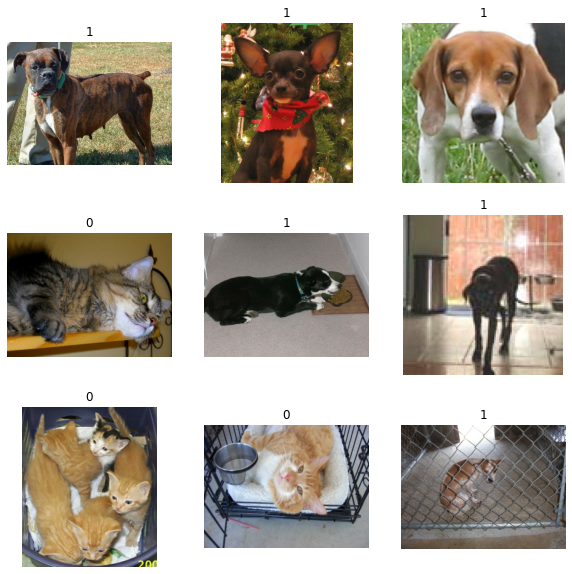

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

In [ ]:
size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

In [ ]:
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

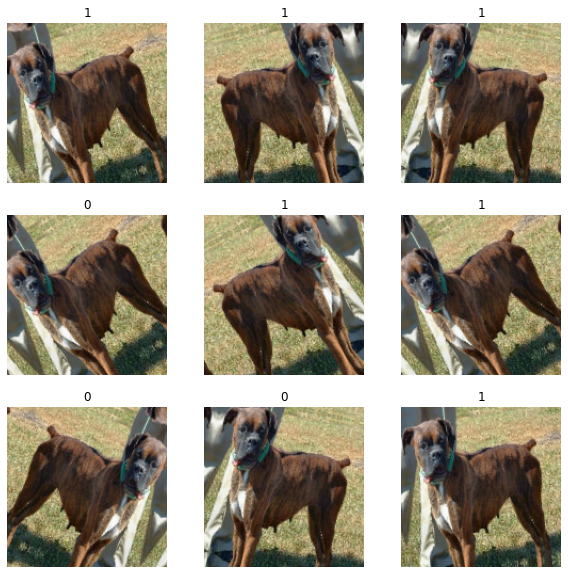

In [ ]:
import numpy as np

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[i]))
        plt.axis("off")

## Build a model



In [ ]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be normalized
# from (0, 255) to a range (-1., +1.), the normalization layer
# does the following, outputs = (inputs - mean) / sqrt(var)
norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2
# Scale inputs to [-1, +1]
x = norm_layer(x)
norm_layer.set_weights([mean, var])

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

83689472/83683744 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 150, 150, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 150, 150, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
______________________________________________________________

## Train the top layer

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/20
291/291 [==============================] - 33s 83ms/step - loss: 0.2471 - binary_accuracy: 0.8802 - val_loss: 0.0822 - val_binary_accuracy: 0.9673
Epoch 2/20
291/291 [==============================] - 23s 79ms/step - loss: 0.1259 - binary_accuracy: 0.9499 - val_loss: 0.0757 - val_binary_accuracy: 0.9716
Epoch 3/20
291/291 [==============================] - 23s 80ms/step - loss: 0.1182 - binary_accuracy: 0.9508 - val_loss: 0.0725 - val_binary_accuracy: 0.9721
Epoch 4/20
291/291 [==============================] - 23s 78ms/step - loss: 0.1142 - binary_accuracy: 0.9536 - val_loss: 0.0836 - val_binary_accuracy: 0.9686
Epoch 5/20
291/291 [==============================] - 23s 78ms/step - loss: 0.1062 - binary_accuracy: 0.9528 - val_loss: 0.0753 - val_binary_accuracy: 0.9699
Epoch 6/20
291/291 [==============================] - 23s 79ms/step - loss: 0.1105 - binary_accuracy: 0.9534 - val_loss: 0.0720 - val_binary_accuracy: 0.9721
Epoch 7/20
291/291 [==============================] 

## Do a round of fine-tuning of the entire model



In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 10
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 150, 150, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 150, 150, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049  